# PSET 9: <br>Quantum Chemistry, Solar cells<br> and Molecular Screening

This pset will guide trough some of the current efforts in utilizing theoretical chemistry methods to solve material problems, via high-throughput screensing of molecules. You'll get a sense of what it's like to generate and run calculations on a larger scale molecular library. Molecular libraries are being used to screen for molecules with promising properties in the fields of organic photovoltacis, organic LED's, flow batteries, among many others.

We'll pretend that we're building and screening a library of organic molecules for photovoltaics applications. Once we have some electronic structure properties of the molecules (specifically, estimates for the HOMO and LUMO energies), we'll use a simple model called the Scharber Model to predict the Energy Conversion efficiency that we'd obtain if we used these molecules as donor molecules in an organic solar cell.


It is divided in 4 parts:

* Intro Quantum Chemistry Calculations with Pyquante
* Generating multiple molecules with RDKIT
* Modeling Power Conversion Efficiency of Dye sensitive solar cells with the Scharber Model
* Screening of molecules

It might seem really long, but that is because there is a lot of ideas to cover...we have kept a lot of the code light so that you focus more on the ideas.

This aplication is based off on the Harvard Clean Energy Project, led by the Aspuru Guzik Group in the Chemistry department. You can find a lot more info by cliking on this icon:

[![](http://aspuru.chem.harvard.edu/blog/wp-content/uploads/2012/02/CEPicon.jpg)](http://cleanenergy.molecularspace.org/)

**NOTE:** The purpose of the notebook is just to give you a feel for large scale molecular screening. Since we'll be running many calculations in your laptop's virtual machine, we'll have to use relatively cheap and fast methods called Semi-Empirical methods. So don't trust the values that we predict too much...

## Load preliminaries

In [1]:
#Here is what we usually import
% matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps
# PyQuante!
from PyQuante.Molecule import Molecule
from PyQuante import SCF
from PyQuante.MP import MP2
#RDKIT
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PyMol
##this let's us print out the available functions in our library,
## as well as the documentation
import pydoc 
# add all probables spots for the quantum world library
import sys
sys.path.append('../library')
#This is how we'll import our own home-made modules
import quantumWorld as qworld
qworld.fancy_plotting()

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# <i class="fa fa-check-circle-o"></i> Exercise 1: <br>  Small Quantum Chemistry exploration of Hydrogen Flouride!
## 1 point

![](http://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Hydrogen-fluoride-3D-balls.png/320px-Hydrogen-fluoride-3D-balls.png)


**Goals:**

* Find equilibrium geometry by varying bond distance.
* Compare geometry with various levels of theory PM3, HF, DFT.



For this we will utilize everyone's favorite quantum chile:

![fake pyquante](files/PyQuante.jpg)
From [pyquante's website](http://pyquante.sourceforge.net/):
>PyQuante is an open-source suite of programs for developing quantum chemistry methods.
> The goal of this software is not necessarily to provide a working quantum chemistry program
>, but rather to provide a well-engineered set of tools so that scientists can construct 
> their own quantum chemistry programs without going through the tedium of having to write 
> every low-level routine.



### Equilibrium Geometry 
Since this is a two-atom molecule we only need to vary the coordinates of the molecules' nuclei by changing bond distances and see how the energy of the ground state (obtained via a Hartree-Fock calculation) changes with geometry.  We'll compare some of our first-principle estimates with experimental values (e.g. equilibrium bond distances).  

### Defining a Molecule
Recall that to create a molecule object you have to do something like:
```python
my_mol = Molecule('MyMolName', atomlist = [atom1, atom2], units = 'Angstroms')
```
Where atom1 and atom2 are of the form:
```python
atom1 = (#, (x, y, z))
```

Where # is the atomic number, and (x,y,z) are the coordinates. 

In [4]:
atom_H = (1,(0,0,0))
atom_F = (9,(1,0,0))
molecule = Molecule('HF', atomlist = [atom_H,atom_F], units = 'Angstroms')
molecule


Molecule: HF
	Atom ID: 0 Atomic Num:  1 ( 0.000, 0.000, 0.000)
	Atom ID: 1 Atomic Num:  9 ( 1.890, 0.000, 0.000)

###  <i class="fa fa-eye"></i>  3D representation

You can use your mouse to rotate and zoom in!

In [5]:
qworld.visualize_Mol(molecule,angstroms=True)

FormatUnsupported: Can't recognize the format 'xyz' supplied

## 1.a) Single Point Energy calculations

Write a function that returns a Pyquante molecule representing Hydrogen Fluoride (HF) given a bond length

**Input**: a bond distance $r_0$

**Ouput**: Pyquante molecule

Write the function below 

In [6]:
def HF_geometry(r0):
    '''r0 is bond length
    Refere to diagram above for atom nomenclature
    '''
    ############# Two lines #############################
    #Create an atom called H and an atom called F.  Use the PyQuante format mentioned above. 
    #Set the H atom at the origin.  And set the F atom at position (r0, 0, 0)

    atom_H = (1, (0,0,0))
    atom_F = (9, (r0,0,0))
    
    ###################################################
    
    #######ONE LINE#########
    #Generate PyQuante Molecule caled molecule, with the atomlist [H,F] and units of Angstroms
    
    molecule = Molecule('HF', atomlist = [atom_H,atom_F], units = 'Angstroms')
    
    ##########################################################
    return molecule

### Get experimental bond distance
Go to [wikipedia](https://www.wikipedia.org), [cccdbd](http://cccbdb.nist.gov/) or wherever you want, and find the value for the bond distance of Hydrogen Fluoride.  Call that value **r0**. And then use the function above to create a PyQuante molecule called HF (for Hydrogen Fluoride, not for Hartree Fock) with that bond distance. 

In [7]:
r0 = 0.917
HF_exp = HF_geometry(r0)

### Get the energy for a single bond distance

We are going to use PyQuante to call the **Restricted Hartree-Fock Method** (RHF) along with the default basis set **6-31G****. This is the first line of attack when trying to solve the Schrödinger equation with wavefunctions.

I'll show you how this is done for a single bond distance, what is normally called a **single point calculation**. 

1. **SCF function**, which defines how we will solve the electronic structure. **SCF** stands for self consistent field.
2. **iterate()**, which procceds to solve the problem iteratively and build solutions until the the energy does not change between one iteration to the other one (*self-consistency*).

In [8]:
solver = SCF(HF_exp,method='RHF')
solver.iterate()
print('The ground state energy is --> %f'%solver.energy)

The ground state energy is --> -100.011350


#### We just did a calculation, so fast!

Right now we just have to work with energy values, but later on we will want to calculate bandgaps ($E_{gap})$ and other properties such as  **orbital energies** and **number of closed shell** will be benefitial.



## 1.b ) Calculate the PES for HF

Now, based on the example I gave you above, you should be able to get the energy of Hydrogen Fluoride as a function of bond distance.  In the cell below: 

1. Create an array with many distances (say from 0.3 to 2 in intervals of 0.05).
2. Create an array of zeros, same length as your position array. 
3.  Write a for loop, where at each iteration you do the following:
    * Construct a HF molecule with the apropriate bond distance 
    * Run a Hartree Fock calculation on that molecule, getting the energy, orbitals, and orbital energies
    * Store the energy for that bond distance in the energy array. 
4. Plot the energy vs distance of separation.

** Note: ** Some calculations at close or large distances might not converge. No problem, just use as is. Non-convergence happends sometimes.



In [9]:
############# about 7 - 9 lines #######
bondlength_array = np.concatenate([np.arange(.25,2,.1),np.arange(.7,.9,.05),np.arange(.90,.95,.005)])
bondlength_array = np.unique(bondlength_array)
print(bondlength_array)
energy_hf = np.zeros(len(bondlength_array))
for i,bondlength in enumerate(bondlength_array): 
    mol = HF_geometry(bondlength)
    print("calculating... %f"%bondlength)
    solver = SCF(mol ,method='RHF')
    solver.iterate()
    energy_hf[i] = solver.energy

[ 0.25   0.35   0.45   0.55   0.65   0.7    0.75   0.75   0.8    0.85   0.85
  0.9    0.9    0.905  0.91   0.915  0.92   0.925  0.93   0.935  0.94
  0.945  0.95   1.05   1.15   1.25   1.35   1.45   1.55   1.65   1.75   1.85
  1.95 ]
calculating... 0.250000
calculating... 0.350000
calculating... 0.450000
calculating... 0.550000
calculating... 0.650000
calculating... 0.700000
calculating... 0.750000
calculating... 0.750000
calculating... 0.800000
calculating... 0.850000
calculating... 0.850000
calculating... 0.900000
calculating... 0.900000
calculating... 0.905000
calculating... 0.910000
calculating... 0.915000
calculating... 0.920000
calculating... 0.925000
calculating... 0.930000
calculating... 0.935000
calculating... 0.940000
calculating... 0.945000
calculating... 0.950000
calculating... 1.050000
calculating... 1.150000
calculating... 1.250000
calculating... 1.350000
calculating... 1.450000
calculating... 1.550000
calculating... 1.650000
calculating... 1.750000
calculating... 1.850000

### <i class="fa fa-line-chart"></i> Plot the energy as a function of bond dinstance

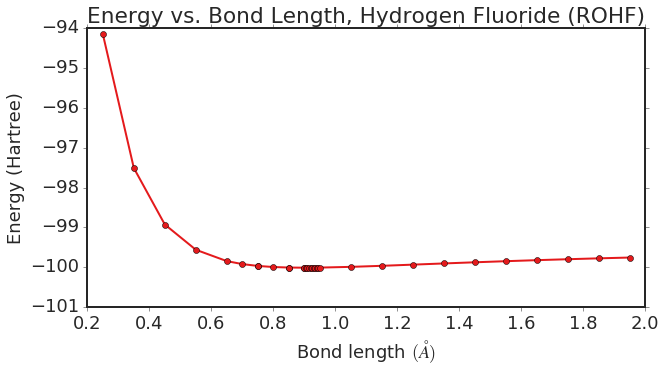

In [9]:
plt.plot(bondlength_array, energy_hf, '-o')
plt.xlabel('Bond length $(\AA)$')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs. Bond Length, Hydrogen Fluoride (ROHF)')
plt.show()

#### <i class="fa fa-question-circle"></i>  Thinking points ... <br> For what bond distance do you get the minimum energy?  <br> How does this compare to the bond distance in Wikipedia?

**Hint:** argmin function in numpy might be useful to recover the index of the bond distance corresponding to this minimal energy. 

In [10]:
index = np.argmin(energy_hf)
min_bondlength = bondlength_array[index]
min_energy = energy_hf[index]
print( "Minimum energy is %f at bond distance %f"%(min_energy,min_bondlength))

Minimum energy is -100.011690 at bond distance 0.900000


Answere here

## 1.c: Expanding to other Methods 

There are other methods besides **RHF** based on other theories of electronic structure.
Chosing a method is always a balance between computing speed and accuracy. 
Sometimes your molecule is very big and you need a cheap but less acurate method, or sometimes you need a lot of precision and have some computation time to spare.

<br>

### The Quantum Chemistry Panorama (stationary)

![](files/QC_panorama.png)

Here $x$ means electron 'positions' and $R$ nuclei coordinates.
There are multiple apporaches to solving the Schrodinger equation under the Born-Oppenheimer approximation, to summarize the main ideas behind them:

* **DFT** Based on charge density, a physical measurable, pretty cheap $\mathcal{O}(n^3)-\mathcal{O}(n^4)$ and accurate, not 100% reliable. You have to decide on a functional and a basis set. Also **the Hohenberg-Kohn theorems** state that any molecular property can be derived from the charge density and there exists a universal functional which will solve all your problems.
* **Hartree-Fock and Post-HF** Pretty expensive $\mathcal{O}(n^3)-\mathcal{O}(n!)$, but reliable and there is a clear idea of how to systematically improve your solution and to arrive to the exact theoretical limit.
* **Quantum Monte Carlo** Highly accurate, extremely parallelizable (100k computers @ 99% efficiency) and scaling at $\mathcal{O}(n^3)$. Solves the $n^3$ dimentional integral of $\langle \psi | H | \psi \rangle$ via stochastic integration. In a sense you are simulating the electrons drifting, difussing and interacting randomly around your atoms.
* **Semi-empirical:** Relies on force fields, parameterizations, model-fitting and other neat tricks to get cheap and semi accurate results for a fraction of the cost. 
* ** Pertubation-Theory** Many methods can be enchanced by treating missing effects via pertubations.

For this we will try three other methods:
* **MINDO3** as in Modified Intermediate Neglect of Differential Overlap (**method=MINDO3** option), a cheap empirical method that is based on Hartree-Fock, but does a lot of tricks, and fitting of parameters to cut corners on computation.
* **DFT** as in Density Functional Theory (**method=dft** option), a ab-initio method that uses charge density to calculate properties. It has an extra parameter called functional, we will use the default one (SVWN).
* **MP2** as in moller plesset perturbation theory level 2 (**MP2** function). Based on a HF wavefuntion we perturb the solution to get a correction term that partially takes in to account the interactions between closed and open orbitals.

There are many details to account for when running a calculation, such as basis set or the choice of a functional (DFT), always be catious when making generalizations about methods.

<br>

### Example Single point energy calculations with MINDO3, DFT and MP2

**Note:**A small quick on PyQuante, any time you use MINDO3 along with another method (e.g. DFT), you should rebuild your molecule ( mol = Molecule(....)) from scratch if not it will alter the computation of other messages.

In [11]:
HF_exp = HF_geometry(r0)
method='MINDO3'
solver1 = SCF(HF_exp, method=method)
solver1.iterate()
print("Final %s energy for system HF is %f"%(method,solver1.energy))

Final MINDO3 energy for system HF is -64.025180


In [12]:
HF_exp = HF_geometry(r0)
method='DFT'
solver1 = SCF(HF_exp, method=method)
solver1.iterate()
print("Final %s energy for system HF is %f"%(method,solver1.energy))

Final DFT energy for system HF is -99.773550


In [13]:
method='HF'
solver = SCF(HF_exp,method=method)
solver.iterate()
nclosed,nopen = HF_exp.get_closedopen()
nbf = len(solver.basis_set.get())
emp2 = MP2(solver.ERI,solver.solver.orbs,solver.solver.orbe,nclosed,nbf-nclosed)
print("MP2 corrected enery for system HF is %f"%(solver.energy+emp2))

MP2 corrected enery for system HF is -100.196666


#### MP2 requires more code
So here are utility functions, to one-line it!


In [14]:
def MP2_energy(molecule):
    solver = SCF(molecule, method='HF')
    solver.iterate()
    nclosed,nopen = molecule.get_closedopen()
    nbf = len(solver.basis_set.get())
    emp2 = MP2(solver.ERI,solver.solver.orbs,solver.solver.orbe,nclosed,nbf-nclosed)
    energy= solver.energy + emp2
    return energy

def SPE_energy(molecule,method):
    if method == 'MP2':
        energy = MP2_energy(molecule)
    else :
        solver = SCF(molecule, method=method)
        solver.iterate()
        energy = solver.energy
    return energy

### Find Equilibrium Geometry with DFT and MP2
Make another for-loop over bond-distances, like in the previous part, just remember to save the values in seperate arrays, we want to compare them at the end

In [15]:
energy_dft = np.zeros(len(bondlength_array))
energy_mp2 = np.zeros(len(bondlength_array))

for i,bondlength in enumerate(bondlength_array): 
    print("calculating...%f"%bondlength)
    #get geometry
    mol = HF_geometry(bondlength_array[i])
    #dft
    energy_dft[i] = SPE_energy(mol,'DFT')
    # MP2
    energy_mp2[i] = SPE_energy(mol,'MP2')


calculating...0.250000
calculating...0.350000
calculating...0.450000
calculating...0.550000
calculating...0.650000
calculating...0.700000
calculating...0.750000
calculating...0.750000
calculating...0.800000
calculating...0.850000
calculating...0.850000
calculating...0.900000
calculating...0.900000
calculating...0.905000
calculating...0.910000
calculating...0.915000
calculating...0.920000
calculating...0.925000
calculating...0.930000
calculating...0.935000
calculating...0.940000
calculating...0.945000
calculating...0.950000
calculating...1.050000
calculating...1.150000
calculating...1.250000
calculating...1.350000
calculating...1.450000
calculating...1.550000
calculating...1.650000
calculating...1.750000
calculating...1.850000
calculating...1.950000


### <i class="fa fa-line-chart"></i>  Now plot your results and compare lengths

** <i class="fa fa-exclamation-triangle"></i> Disclaimer:** Normally you should not directly compare energy values as face values, since DFT/MP2/HF treat different hamiltonians, so they are not directly comparable.

But you can compare relative values (energy differences) or geometrical features such as equilibrium bond lengths.

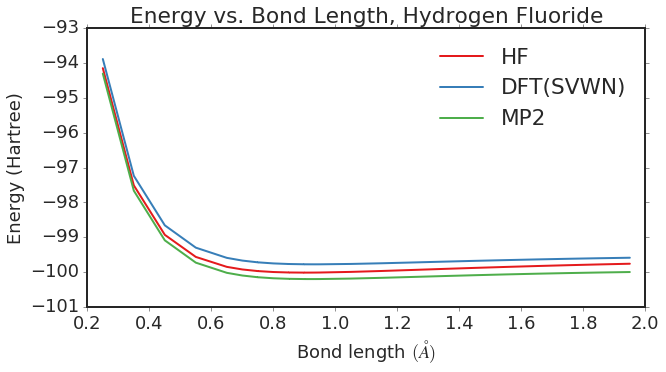

In [17]:
plt.plot(bondlength_array, energy_hf, '-',label='HF')
plt.plot(bondlength_array, energy_dft, '-',label='DFT(SVWN)')
plt.plot(bondlength_array, energy_mp2, '-',label='MP2')

plt.xlabel('Bond length $(\AA)$')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs. Bond Length, Hydrogen Fluoride')
plt.legend()
plt.show()

### Compare with FULLCI/6-31G

We can compare with an almost exact level of theory, a FULL Configuration Interaction, this methods treats the ground state wavefunction as a linear combinations of ALL posible excitations for the 6-31G basis set. There are  MANY posibilities for excitations (a factorially large number), so this method is only available for small systems and can be considered 99.999% Exact.

You can load the data by running:
```
data = np.loadtxt('files/HF_fullci.dat')
r = data[:,0]
energy_fullci = data[:,1]
```

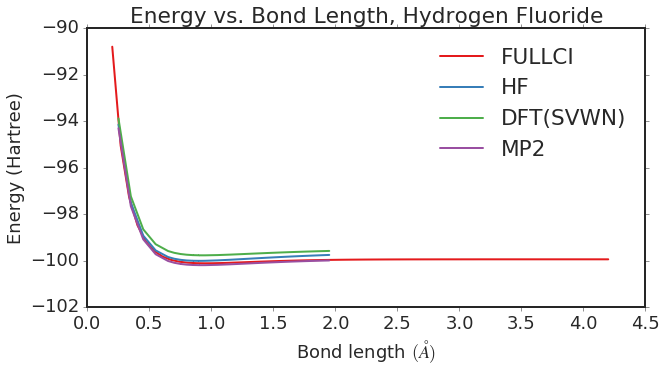

In [18]:
data = np.loadtxt('files/HF_fullci.dat')
r_fullci = data[:,0]
energy_fullci = data[:,1]

plt.plot(r_fullci , energy_fullci, '-',label='FULLCI')
plt.plot(bondlength_array, energy_hf, '-',label='HF')
plt.plot(bondlength_array, energy_dft, '-',label='DFT(SVWN)')
plt.plot(bondlength_array, energy_mp2, '-',label='MP2')

plt.xlabel('Bond length $(\AA)$')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs. Bond Length, Hydrogen Fluoride')
plt.legend()
plt.show()


#### <i class="fa fa-question-circle"></i>  Thinking points ...

* Which theory gives a bond length closer to experiment? and to the FULLCI?
* How do the curves compare qualitatively?
* Where do the different methods look alike, where do they differ?

# <i class="fa fa-check-circle-o"></i> Exercise 2: Molecular library
## 1 point

The molecules we are interested in making are for Dye Sensitive Solar cells (DSSC) , here is a diagram of one:

[![](files/dye.png)](https://en.wikipedia.org/wiki/Dye-sensitized_solar_cell)

One of the most important part in this solar cell is the **dye**, the molecules that compose this part absorb more readily photons of a certain frequency.
The color of the dye is determined by the band gap, the frequencies less than the gap are reflected and those higher than the gap are absorbed.  So bandgap of the molecules that comprise the dye are directly related to efficiency of a DSSC.

If we want to build a good DSSC we need a molecule with the following properties:

* Organic, since it will be cheaper and more eco-friendly.
* Easily Synthesizable (Can be synthesized in a few common steps from common materials).
* Colored, so that it can absorb specific frequencies of light.
* And hence a band-gap, that will give us a good power efficency when taking into account the solar spectrum.

With this in mind we can start building our molecules!



## 2.a) Defining reactions and fragments
The first step to start using rdkit to make our molecular library is to define the types of "reactions" that are allowed. Without going into too much detail, the two lines below define two different types of reactions: fusion and linking. You'll get a sense of what they mean further down.

In [19]:
linking_reaction = AllChem.ReactionFromSmarts('[cH1,nH1:1].[cH1:2]>>[*:1]-[*:2]')
fusion_reaction = AllChem.ReactionFromSmarts('[a:7]~1~[a:8]~[a:9]~[cH:1][cH:2]~[a:10]~1.[a:5][c;H1:3][c;H1:4][a:6]>>[*:7]~1~[*:8]~[*:9]~[*:1](:[*:5])~[*:2](:[*:6])~[*:10]~1.[*:3][*:4]')

Next, we'll define the set of fragments from which we'll build our entire molecular library. The fragments are defined in a string format that is now as the SMILES string format.  **SMILES** stands for simplified molecular-input line-entry system.

You can read up on the specifics of the syntax in the [webs](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

In [20]:
#This is the list of fragments, in SMILES format,  that we'll be working with: 
fragments = ["C1=CC=CC=C1","C1=CC=NC=C1","N1=CC=NC=C1","N1C=CC=C1","O1C=CC=C1"]

Ok, so now we have those fragments.... but what do they look like? 

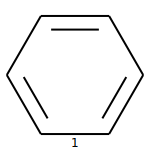

In [22]:
reactants = [AllChem.MolFromSmiles(i) for i in fragments]
labels = [str(i+1) for i in range(6)]
Draw.MolsToGridImage(reactants, legends = labels, molsPerRow = 5, subImgSize=(150,150))    

### <i class="fa fa-question-circle"></i>  Do you recognize them? 

0. Benzene
1. Pyridine
2. Pyrazine
3. Pyrrole
4. Furan

## 2.b) Building the 1st generation library 
As a next step, we'll start "mating" these fragments, in order to generate molecules that are composed of pairs of fragments.  These pairs can either be "linked" or they can be "fused"

### I'll first show you what I want you to do for a single pair of fragments:

### Linking

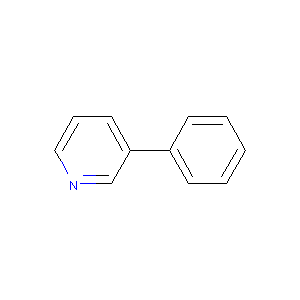

In [23]:
products = [] #start with an empty set
#get a single pair of fragments
r1 = reactants[0]
r2 = reactants[1]
#React them
prods = linking_reaction.RunReactants((r1, r2))
#Store all the products, in smiles format, in the products set
for prod in prods:
    product_SMILES = AllChem.MolToSmiles(prod[0])
    products.append(product_SMILES)

# converto a mol from a smiles an draw
link_mol = AllChem.MolFromSmiles(products[-1])
Draw.MolToImage(link_mol)

### Fusion

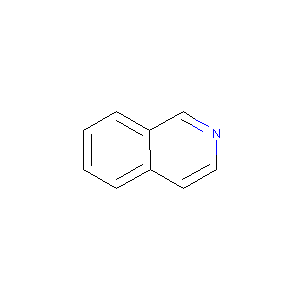

In [24]:
products = [] #start with an empty set
#get a single pair of fragments
r1 = reactants[0]
r2 = reactants[1]
#React them
prods = fusion_reaction.RunReactants((r1, r2))
#Store all the products, in smiles format, in the products set
for prod in prods:
    product_SMILES = AllChem.MolToSmiles(prod[0])
    products.append(product_SMILES)
    
# converto a mol from a smiles an draw
fusion_mol = AllChem.MolFromSmiles(products[-1])
Draw.MolToImage(fusion_mol)

### Here is where the fun starts.  

Write two nested for-loops:
* #### The first nested for-loop will react all pairs of fragments using the linking reaction. 
* #### The second nested for-loop will react all pairs of fragments using the fusion reactions. 

At the end of each nested for-loop, store the products in the products set! 

In [25]:
#############

products1 = []

#Linking reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in linking_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products1.append(product_SMILES)

#Fusion reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in fusion_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products1.append(product_SMILES)
            
###############
# get ony unique values
products1 = list(set(products1))
print('The total number of 1st generation molecules is ---> %d'%len(products1))

The total number of 1st generation molecules is ---> 87


### <i class="fa fa-eye"></i> Let's look a the products
The products are smiles strings (you can verify by printing products).
We want to see what they look like, so we'll convert the smiles to rdkit molecules. 

In [26]:
gen1 = [AllChem.MolFromSmiles(i) for i in products1]

Now let's see what our first generation library looks like: 

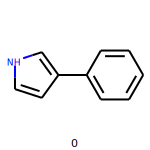

In [27]:
Draw.MolsToGridImage(gen1, legends = [str(i) for i in range(len(gen1))], molsPerRow = 6, subImgSize=(150,150))

<i class="fa fa-smile-o"></i> One happy family!


## 2.c) Second generation Library:
Let's take it to the next step! Let's take all the molecules in the list of two-fragment products, and "react" them again with the set of fragments in order to generate a library of three-fragment products. 

### Write again two nested for-loops  
* The first nested for-loop will react all molecules in reactants with all of the fragments using the linking reaction. 
* The second nested for-loop will react all molecules in reactants with all of the fragments using the fusion reaction.

Keep adding the resulting molecules to the list of molecules

#### **NOTE:** since we want to mix all the 1st generation products with the fragments, one for-loop should loop over reactants, while the other should loop over gen1!

In [28]:
#First for loop: linking reactions
products2 = set()

for r1 in reactants:
    for r3 in gen1:
        for prod in linking_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products2.add(product_SMILES)

#Second nested for-loops: fusion reactions. 
for r1 in reactants:
    for r3 in gen1:
        for prod in fusion_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products2.add(product_SMILES)

###############
# get ony unique values
products2 = list(products2)
print('The total number of 2nd generation molecules is ---> %d'%len(products2))

The total number of 2nd generation molecules is ---> 3500


These are way too many molecules to display in our iPython notebook, so in order to visualize them, we'll take a random subset of them, of size 200. 

In [29]:
import random
random.seed()

random_ind = random.sample(range(len(products2)), 200)

And we'll visualize those:

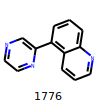

In [30]:
mList = []
# collect all random molecules
for ind in random_ind:
    m = Chem.MolFromSmiles(products2[ind],sanitize=False)
    m.UpdatePropertyCache()
    mList.append(m)
# convert all indices to strings
labels=[str(i) for i in random_ind]
# grid plot
Draw.MolsToGridImage(mList, legends = labels , molsPerRow = 10, subImgSize=(100,100))

# <i class="fa fa-check-circle-o"></i> Exercise 3: <br> Quantum Chemistry + Scharber Model
## 1 point

## Plan:


1. Convert the rdkit molecule to a PyQuante molecule.
2. Calculate the molecule with a cheap electronic structure method.
3. Get the estimates for the HOMO energy and the LUMO energy
4. Apply the Scharber Model with the bandgap and data from solar spectrum




## 3.a) Convert rdkit molecule to a PyQuante molecule


Let's pick our favorite random molecule number **3433**:

In [31]:
#Convert SMILES to rdkit molecule
m = Chem.MolFromSmiles(products2[3433])
#Add all the hydrogen atoms: 
m2=Chem.AddHs(m)
#Get the coordinates of the atoms in 3D space. 
AllChem.EmbedMolecule(m2)
AllChem.UFFOptimizeMolecule(m2)
confo1 = m2.GetConformer()
#and empty list, where we'll add all the coordinates and atom types
coordList = [] 
for i, atom in enumerate( m2.GetAtoms() ):
    coord = confo1.GetAtomPosition(i)
    coordList.append((atom.GetAtomicNum(), (coord.x, coord.y, coord.z)))

#### Now we're ready to create a PyQuante molecule object which we know and love. 

In [32]:
coordList=[(6, (-3.0415213143651596, 1.754836412894468, 1.2037699098489405)), (6, (-2.2141507969424365, 2.0372168718299726, 0.11343487781878032)), (6, (-1.352258906348328, 1.0555062985544599, -0.3846473145540447)), (6, (-1.3034518890102267, -0.21467963573979928, 0.21501735453053838)), (6, (-2.150566104682595, -0.49564709023672654, 1.2993191016996184)), (6, (-3.0117751834667255, 0.48849385739745205, 1.7944090183233887)), (7, (-0.4318072318769353, -1.2336817451089153, -0.30288458588241907)), (6, (-0.8269092615380906, -2.476059648012981, -0.6479658076276628)), (6, (0.22201402868252496, -3.1650336063616313, -1.2204593409708133)), (6, (1.3043090071258967, -2.3088486910523915, -1.2234939569902108)), (6, (0.8757191308374361, -1.1283513815713722, -0.644113008682499)), (6, (1.7568609669640787, 0.027155110947120316, -0.3723385168367808)), (6, (1.6427087209359512, 0.9136934397118472, 0.6843836603239971)), (6, (2.7042628420062544, 1.7887892751967442, 0.5727021119220492)), (6, (3.4256123045344307, 1.395126044948974, -0.535764956280122)), (7, (2.8507889378205826, 0.31937021568751683, -1.1021984284090518)), (1, (-3.708889266627515, 2.515456379970929, 1.5878237018989285)), (1, (-2.243798277350463, 3.01545455198622, -0.3486924824788333)), (1, (-0.7273310131141869, 1.2810246919514656, -1.2393881954778487)), (1, (-2.1334650616106705, -1.47242481162422, 1.7660167588032947)), (1, (-3.6564210400712756, 0.2692399440297537, 2.6357134269263622)), (1, (-1.832349514977934, -2.857363035331585, -0.5211040444302251)), (1, (0.19973799839565426, -4.178829981087813, -1.596970909066033)), (1, (2.2995893406470516, -2.535632478761215, -1.5824444906197306)), (1, (0.896480951019535, 0.9124531508280412, 1.4672696016106925)), (1, (2.9350119346326955, 2.612322151424734, 1.2349673100838472)), (1, (4.328252611085647, 1.8656866263551692, -0.9025744935502771)), (1, (3.193346087294714, -0.18527291882636057, -1.9497863019339063))]
molTest=Molecule('CEPTest',
             atomlist = coordList, units = 'Angstroms')

And let's visualize the 3D structure!

In [33]:
qworld.visualize_Mol(molTest)

## 3.b) Perform an Electronic Structure Calculation with the MINDO/3 SemiEmpirical Method
Since we are going to have to run a TON of electronic structure calculations, and we are doing this in our little virtual machines, we can't really afford to run a ton of Hartree-Fock or DFT calculations.  (Although you may want to try it if you're really brave and want to see how well your laptop performs!!!)

Remember MINDO/3 is a semi-empirical method! Keep that in mind when we produce predictions in this exercise.

In the real world of Quantum Chemistry Research, you would want to have access to a huge cluster which would let you run methods such as **MP2**, **DFT**, or even **Linear Scaling Coupled Cluster Methods** on the huge set of molecules, in order to make sure that your predictions are extremely accurate.  

We can do this in with the **SCF** function we used before, but specifying the method as **'MINDO3'**, save the solver in a variable called **mol_mindo3**.

In [34]:
# Two lines of code, call the solver and iterate!
mol_mindo3 = SCF(molTest, method='MINDO3')
mol_mindo3.iterate()

## 3c) Get HOMO and LUMO Energies


For this we have at our disposal the following methods:

* Orbital Energies (**solver.orbe**), an array of energy values for each MO orbital.
* Number of occupied orbitals (**solver.nclosed**), useful if you want to play with occupied/unoccupied.

In [35]:
# calculate homo and lumo energies -- 3 lines
nclosed = mol_mindo3.nclosed
donor_HOMO = mol_mindo3.orbe[nclosed - 1]
donor_LUMO = mol_mindo3.orbe[nclosed] 
# calculate bandgap
fudge_factor = 5
donor_LUMO-= fudge_factor
gap = donor_LUMO - donor_HOMO 

#### Did you notice that mysterious variable called the fudge_factor?
Basically, we're shifting the the LUMO energy down by that fudge factor, many times calcualtions will not compare directly with experiment so it is nesesary to introduce a calibration in order to give predictive power to calculations.

This is where the **''fudge factor''** comes in..  That's how crappy the semi-empirical methods perform for this particular application.

But nevermind, the point is to get a feel for high-throughput, large scale quantum chemistry calculations for molecular screening. 

### Question:  What color of light will this molecule absorb?

In [36]:
gap_nm=1239.84187/gap
print('the HOMO-LUMO gap, in wavelength (nanometers), is ----> %f nm'%gap_nm)

the HOMO-LUMO gap, in wavelength (nanometers), is ----> 396.603133 nm


## 3.d) Making prections with the Scharber Model 

We can use the Scharber Model to predict the solar cell conversion efficiency if we were to use that molecule as an electron donor in an organic solar cell. 

In order to predict the energy conversion efficiency, we need the solar spectrum. Specifically, we want to rate at which energy from the sun hits the surface of the earth as a function of wavelength. 
<br>
### <i class="fa fa-sun-o"></i> Load the solar spectrum data 
Don't worry to much about the code, we just want to load the data in to some arrays


In [37]:
### Read a file that has the solar spectrum data in it. 
solar_spect = np.loadtxt('files/AM15_PhotFlux_rev.csv',skiprows=1,delimiter=',')
wavelength=solar_spect[:,0]
power=solar_spect[:,1]
flux=solar_spect[:,2]

### <i class="fa fa-line-chart"></i> Graph the solar spectrum
Wavelength vs power

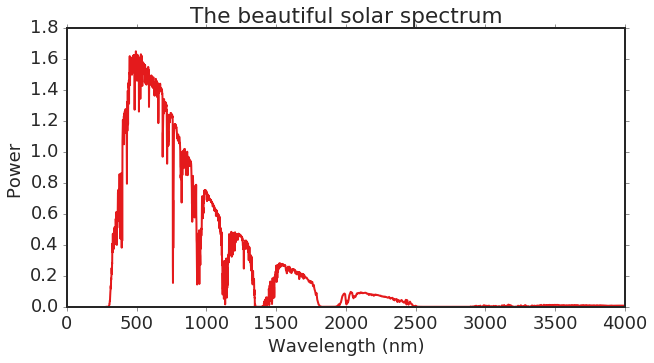

In [38]:
plt.plot(wavelength,power)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power ')
plt.title("The beautiful solar spectrum")
plt.show()

### <i class="fa fa-question-circle"></i>  Questions?

* Which part of the spectrum corresponds to visible light?
* Is there a a maxima? Which color corresponds to this wavelength?


### Putting it all together: Scharber model
Now we'll define a function that, given the **HOMO**,** LUMO**, **power spectrum** (power, wavelength, flux), returns the predicted **Power Conversion Efficiency** (PCE) via the Scharber model.

Although the Scharber model is pretty straightforward, and can be thought of as a specialized version of the [Shockley-Queisser model](https://en.wikipedia.org/wiki/Shockley%E2%80%93Queisser_limit), it is beyond the scope of this iPython notebook to delve into the derivaition.  so lets just use it as a blackbox function. 

In [39]:
def ScharberEfficiency(donorHOMO, donorLUMO, power, wavelength, flux):
    fullPower = simps(power, wavelength)
    #This is the LUMO energy, in eV, of the acceptor molecule, PCBM.
    pcbm_l=-4.3
    
    # This is the open circuit voltage
    voc=abs(donorHOMO)-abs(pcbm_l)-0.3

    #This is the bandgap, in nano-meters, band gap
    bandgap_ev=abs(donorLUMO-donorHOMO)
    bandgap=1239.84187/bandgap_ev 
    
    wavelength_range=[]
    power_range=[]
    flux_range=[]

    #determine what we will integrate --> only those wavelengths of the solar spectrum shorter than the band gap wavelength
    for i in range(len(wavelength)):  
        if wavelength[i]<bandgap: #we'll integrate all wavelengths that are shorter than the band gap. 
            wavelength_range.append(wavelength[i])
            flux_range.append(flux[i])
        else:
            break

            
    #This is the short circuit current
    jsc=simps(flux_range, wavelength_range)
    #This is called the Fill Factor
    jsc=jsc*0.65 # Take away 0.65 for 26%
    
    #Finally, this is the efficiency
    pce=100*voc*jsc/fullPower # Take away 0.65 for 17% 
    
    return pce

Let's see it in action, also note we have a **qworld** utility function to convert bandgaps to rgb colors (**bandgap_to_rgb(bandgap)**) and to draw the colors (**drawColor(color)**)

The Power Conversion Efficiency is ----> 2.159781 %
The Dye color of 3.126152 eV bandgap is [94, 0, 193] 


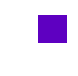

In [40]:
pce = ScharberEfficiency(donor_HOMO, donor_LUMO, power, wavelength,flux)
gap = donor_LUMO-donor_HOMO
color = qworld.bandgap_to_rgb(gap)
# print stuff
print('The Power Conversion Efficiency is ----> %f %%'%(pce))
print('The Dye color of %f eV bandgap is %s '%(gap,str(color)))
qworld.drawColor(color)

# <i class="fa fa-check-circle-o"></i> Exercise 4: Molecular Screening Party
## 1 point


### Now, show us what you've learned in this course by repeating all the steps we did above but for a random set of N molecules!!  YEAH!!!!!

Where **N** is your favorite number larger than 50.

But first, make use of good programming practices by wrapping each module/step of what we've done above in a set of little functions. 

Note that we have worked out above all the pieces of the puzzle above!



### <i class="fa fa-code"></i> Get conformer coordinates from rdkit molecule:

Write a function called rdkit_to_PyQuante which takes as input a molecule in smiles format and returns a PyQuante molecule

In [41]:
def rdkit_to_PyQuante(mol_smiles):
    ###########################################################
    #Convert SMILES to rdkit molecule
    m = Chem.MolFromSmiles(mol_smiles)
    #Add all the hydrogen atoms: 
    m2=Chem.AddHs(m)
    #Get the coordinates of the atoms in 3D space. 
    AllChem.EmbedMolecule(m2)
    AllChem.UFFOptimizeMolecule(m2)
    confo1 = m2.GetConformer()
    #and empty list, where we'll add all the coordinates and atom types
    coordList = [] 
    for i, atom in enumerate( m2.GetAtoms() ):
        coord = confo1.GetAtomPosition(i)
        coordList.append((atom.GetAtomicNum(), (coord.x, coord.y, coord.z)))
    molTest=Molecule('CEPTest',
             atomlist = coordList, units = 'Angstroms')
    ###############################################################
    return molTest 

### <i class="fa fa-code"></i> MINDO/3 electronic structure calculation
write a function called mindo3_calc which takes as input a PyQuante molecule, and returns the molecule object that results from performing the SCF iterations. 

In [42]:
def mindo3_calc(molecule):
    ##################################################
    mol_mindo3 = SCF(molecule, method='MINDO3')
    mol_mindo3.iterate()
    ##################################################
    return mol_mindo3

### <i class="fa fa-code"></i> Get HOMO and LUMO energies
write a function called getHOMO_LUMO which takes as input the output of mindo3_calc, and returns the HOMO and LUMO energies. Include the fudgefactor!

In [43]:
def getHOMO_LUMO(molecule_mindo3):
    #########################################################
    # calculate homo and lumo energies -- 3 lines
    nclosed = molecule_mindo3.nclosed
    donor_HOMO = molecule_mindo3.orbe[nclosed - 1]
    donor_LUMO = molecule_mindo3.orbe[nclosed] 
    # calculate bandgap
    fudge_factor = 5
    donor_LUMO-= fudge_factor
    gap = donor_LUMO - donor_HOMO 
    #######################################################
    return (donor_HOMO, donor_LUMO)

## Get the PCE for a random subset of N  molecules, storing it in an array!

Now generate a random set of indices between **0 and (len(products2) - 1)**.

That's the library that you'll analyze!

In [44]:
n=50
rand_ind = random.sample(range(len(products2)),n)

Using the functions you defined above, get the Power Conversion Efficiency (PCE) of every molecule in your subset, you will want to store the following values:

* Indices with **rand_ind**, we already have these.
* Bandgap values with **gap_array**.
* PCE values with **pce_array**.

Don't worry if PyQuante fails to converge...this happends sometimes

In [46]:
pce_array = np.zeros(len(rand_ind))
gap_array = np.zeros(len(rand_ind))
smiles = []
for i,r_index in enumerate(rand_ind):
    # save the smiles in to the list
    smiles.append(products2[r_index])
    ########################################################
    #generate PyQuante molecules
    molecule = rdkit_to_PyQuante(products2[r_index])
    #run MINDO/3 electronic structure calculation
    molecule_mindo3=mindo3_calc(molecule)
    #Get the HOMO and LUMO energies
    donor_HOMO, donor_LUMO =getHOMO_LUMO(molecule_mindo3)
    #Estimate the power conversion efficiency
    pce = ScharberEfficiency(donor_HOMO, donor_LUMO, power, wavelength,flux)
    ########################################################
    # save the values
    pce_array[i] = pce
    gap_array[i] = donor_LUMO-donor_HOMO
    # print your progress
    print("Calc # {:5d} , Mol index {:5d} with pce = {:10.6f} %%".format(i,r_index,pce))


Calc #     0 , Mol index  1438 with pce =   0.384423 %%
Calc #     1 , Mol index   289 with pce =   2.377327 %%
Calc #     2 , Mol index  3403 with pce =  13.569540 %%
Calc #     3 , Mol index  2123 with pce =   1.427840 %%
Calc #     4 , Mol index  2181 with pce =   2.095255 %%
Calc #     5 , Mol index   205 with pce =   4.211038 %%
Calc #     6 , Mol index  1537 with pce =   2.968862 %%
Calc #     7 , Mol index  3038 with pce =   1.229755 %%
Calc #     8 , Mol index  1387 with pce =   2.080211 %%
Calc #     9 , Mol index  2545 with pce =   1.310148 %%
Calc #    10 , Mol index  1486 with pce =   2.470028 %%
Calc #    11 , Mol index  2108 with pce =   1.800625 %%
Calc #    12 , Mol index   317 with pce =   1.672175 %%
Calc #    13 , Mol index   673 with pce =   0.697925 %%
Calc #    14 , Mol index   718 with pce =   1.888004 %%
Calc #    15 , Mol index  3464 with pce =   2.970064 %%
Calc #    16 , Mol index  2116 with pce =   1.807836 %%
Calc #    17 , Mol index  1050 with pce =  10.73

### Histogram!
A histogram will gives an idea if we found some good molecules and how many

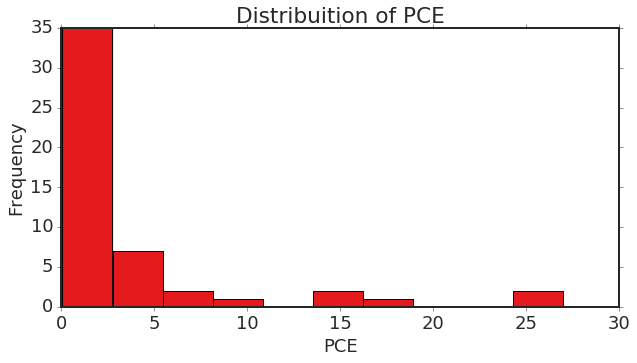

In [47]:
#histogram code
plt.hist(pce_array)
# stuff
plt.ylabel("Frequency")
plt.xlabel("PCE")
plt.title('Distribuition of PCE')
plt.show()

## Competition time !
* ### Get the indices of your Top Ten Performing molecules. 
* ### Display them below, the same way we did above. 
* ### Print out their predicted PCE values, sorted from lowest to highest!
* ### Get info on their colours!

## Will your molecule reign supreme?



![](files/molwinner.png)
### Top ten code here:

# Finally, share your results!
## We will create a database of the entire Chem160 calculations

And see who found the **best** molecule!

Just run the following code and append it your homework submission...we will aggregate the results of your calcualtions and show them during a class hour/section.


In [206]:
name= 'FILL_ME'

# write file
import csv
with open('%s_calcs.tsv'%name, 'wb') as csvfile:
    awriter = csv.writer(csvfile, delimiter='\t')
    for indx,item in enumerate(rand_ind):
        awriter.writerow([indx,item,name,smiles[indx],gap_array[indx],pce_array[indx]])
print('file created')

file created


# <i class="fa fa-check-circle-o"></i> Exercise 5: <br> Conceptual questions (1 point)

Answer the following questions, try to be concise but also do not leave out any important details. Use links to backup your arguments, empty-claims are frowned upon.

1. Give three concrete examples that could be applied to this exercise to improve the molecular screening. Consider you have finite resources, so you cannot do realisitically a FULLCI on all molecules (Not even one). Some example: I would add a funcitional group XX because ..., instead of MINDO3 I would use ..., etc.

2. Besides Dye-sensitive solar cells, What are the limits of DSSCs? what other types of solar cells could be studied/discovered instead using molecular screening?  How would you have to change the workflow? What type of properties would you study?

3. Why do we need Quantum Mechanics for finding solar cells? (MINDO3 is a classical approximation) What quantum effects are in play if we want to build solar cells?

4. Provide a link or article of another example of how molecular screening is used for computational material design.


*Note:* A good starting point would be [Havard's Clean Energy Project](http://cleanenergy.molecularspace.org/) website and their article [Lead candidates for high-performance organic photovoltaics from high-throughput quantum chemistry](http://pubs.rsc.org/en/content/articlelanding/2013/ee/c3ee42756k#!divAbstract).


### <i class="fa fa-check-circle"></i> Answer key:

1. Multiple posibilities:
    * MINDO3 is really bad, but you could use PM7 or PM6 which actually works decently.
    * TDDFT would be used to get accurate absortion spectra.
    * Structures are currently limited to 2-3 linked/fusied fragments, high performing molecules have from 6 to 9.
    * Instead of generating all molecules at once, build incrementaling your library by identifying successful geoemtrical features of high performing molecules.
    * Change some fucntional groups ..
    * Consider more symetric molecules since these might be easier to synthesize.
    
2. Multiple posibilities:
3. As can be show MINDO3 is really bad, so you really need a method that models the correct physics. Solar cells can be studied within the framework of P-N junctions
4. 

# Hope you have enjoyed these psets!